<a href="https://colab.research.google.com/github/ishankaul1/cs5262/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Intro**

For this assignment, I will be undoing and experimenting with my feature engineering for the 'timestamp' column in my dataset. 
In the previous assignments, I transformed the timestamp column into 'seasons' and 'during_restrictions' (meaning whether or not the data was collected during covid restrictions), and then dropped the original timestamp column. However, I never actually performed testing on whether this feature engineering plan affected the model. For this assignment, I will run the same model over several different configurations of this feature engineering task to determine whether or not it actually improves the model.

In addition, since I'm also curious to know whether my data is a better predictor of stress than the combined version of stress and shouting, I'll be dropping the shout column completely and only attempting to predict whether stress levels were greater than a '2' on a scale of 0 to 5.

My feature engineering plan for the experiment is:


1) Produce 4 different 'versions' of the same dataset. All will have the original Timestamp, Daily Shouting, and Wellbeing Score columns dropped, with the rest of the data intact and transformed the same way I did it in Assignments 1-5.
  Version 1: Both during_restrictions and season are in the dataset.
  Version 2: Only seasons is contained in the dataset.
  Version 3: Only during_restrictions is contained in the dataset.
  Version 4 (Control): Neither column in the dataset.

2) Create 4 different pipelines, each fed by the different datasets I created in step 1). The rest of the pipeline will be the exact same as the original Random Forest pipeline I ran in Assignment 5, except with a smaller range of hyperparameters centered around where my model seemed to perform best.

3) Compare the results of the best estimator for the 4 different models to determine whether either of these columns actually have any predictive power towards daily stress.

**Setup**

In [7]:
#Import necessary libraries and read data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

wellbeing_data = pd.read_csv('Wellbeing_and_lifestyle_data_Kaggle.csv')

#Preliminary preprocessing so we can actually work with this data
wellbeing_data = wellbeing_data.drop(['WORK_LIFE_BALANCE_SCORE', 'DAILY_SHOUTING'], axis=1)
wellbeing_data = wellbeing_data[wellbeing_data['DAILY_STRESS'].apply(lambda x: str(x).isdigit())]
wellbeing_data['DAILY_STRESS'] = wellbeing_data['DAILY_STRESS'].astype(str).astype(int)
wellbeing_data['Timestamp'] = pd.to_datetime(wellbeing_data['Timestamp'])

display(wellbeing_data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          15971 non-null  datetime64[ns]
 1   FRUITS_VEGGIES     15971 non-null  int64         
 2   DAILY_STRESS       15971 non-null  int64         
 3   PLACES_VISITED     15971 non-null  int64         
 4   CORE_CIRCLE        15971 non-null  int64         
 5   SUPPORTING_OTHERS  15971 non-null  int64         
 6   SOCIAL_NETWORK     15971 non-null  int64         
 7   ACHIEVEMENT        15971 non-null  int64         
 8   DONATION           15971 non-null  int64         
 9   BMI_RANGE          15971 non-null  int64         
 10  TODO_COMPLETED     15971 non-null  int64         
 11  FLOW               15971 non-null  int64         
 12  DAILY_STEPS        15971 non-null  int64         
 13  LIVE_VISION        15971 non-null  int64         
 14  SLEEP_

None

**Step 1:** Create the four different dataset versions

In [8]:
import datetime

#Transformation functions
def timestamp_to_during_covid_restrictions(l):
  date_start = datetime.datetime(2020, 3, 15)
  date_end = datetime.datetime(2022, 3, 28)
  return list(map(lambda x : x > date_start and x < date_end, l))

def timestamp_to_season(l):
  seasons_list_by_month_index = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter' ]
  return list(map(lambda x : seasons_list_by_month_index[x.month-1], l ))

def stress_to_binary(l):
  return list(map(lambda x : x > 2, l))

#Transformed columns
during_restrictions_col = timestamp_to_during_covid_restrictions(wellbeing_data['Timestamp'])
seasons_col = timestamp_to_season(wellbeing_data['Timestamp'])

#Drop timestamp since we're not going to be using it for any of the pipelines
wellbeing_data = wellbeing_data.drop(['Timestamp'], axis=1)

#extract target for reuse
stress_df = pd.DataFrame()
stress = stress_to_binary(wellbeing_data['DAILY_STRESS'])
stress_df['stress'] = stress

wellbeing_data = wellbeing_data.drop(['DAILY_STRESS'], axis=1)

wellbeing_data = wellbeing_data.dropna()

#Create the four datasets
both_data = wellbeing_data.copy()
both_data['seasons'] = seasons_col
both_data['during_restrictions'] = during_restrictions_col

seasons_data = wellbeing_data.copy()
seasons_data['seasons'] = seasons_col

during_restrictions_data = wellbeing_data.copy()
during_restrictions_data['during_restrictions'] = during_restrictions_col

neither_data = wellbeing_data.copy()


display(both_data.info())
display(seasons_data.info())
display(during_restrictions_data.info())
display(neither_data.info())








<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   FRUITS_VEGGIES       15971 non-null  int64 
 1   PLACES_VISITED       15971 non-null  int64 
 2   CORE_CIRCLE          15971 non-null  int64 
 3   SUPPORTING_OTHERS    15971 non-null  int64 
 4   SOCIAL_NETWORK       15971 non-null  int64 
 5   ACHIEVEMENT          15971 non-null  int64 
 6   DONATION             15971 non-null  int64 
 7   BMI_RANGE            15971 non-null  int64 
 8   TODO_COMPLETED       15971 non-null  int64 
 9   FLOW                 15971 non-null  int64 
 10  DAILY_STEPS          15971 non-null  int64 
 11  LIVE_VISION          15971 non-null  int64 
 12  SLEEP_HOURS          15971 non-null  int64 
 13  LOST_VACATION        15971 non-null  int64 
 14  SUFFICIENT_INCOME    15971 non-null  int64 
 15  PERSONAL_AWARDS      15971 non-null  int64 
 16  TIME

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FRUITS_VEGGIES     15971 non-null  int64 
 1   PLACES_VISITED     15971 non-null  int64 
 2   CORE_CIRCLE        15971 non-null  int64 
 3   SUPPORTING_OTHERS  15971 non-null  int64 
 4   SOCIAL_NETWORK     15971 non-null  int64 
 5   ACHIEVEMENT        15971 non-null  int64 
 6   DONATION           15971 non-null  int64 
 7   BMI_RANGE          15971 non-null  int64 
 8   TODO_COMPLETED     15971 non-null  int64 
 9   FLOW               15971 non-null  int64 
 10  DAILY_STEPS        15971 non-null  int64 
 11  LIVE_VISION        15971 non-null  int64 
 12  SLEEP_HOURS        15971 non-null  int64 
 13  LOST_VACATION      15971 non-null  int64 
 14  SUFFICIENT_INCOME  15971 non-null  int64 
 15  PERSONAL_AWARDS    15971 non-null  int64 
 16  TIME_FOR_PASSION   15971 non-null  int64

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   FRUITS_VEGGIES       15971 non-null  int64 
 1   PLACES_VISITED       15971 non-null  int64 
 2   CORE_CIRCLE          15971 non-null  int64 
 3   SUPPORTING_OTHERS    15971 non-null  int64 
 4   SOCIAL_NETWORK       15971 non-null  int64 
 5   ACHIEVEMENT          15971 non-null  int64 
 6   DONATION             15971 non-null  int64 
 7   BMI_RANGE            15971 non-null  int64 
 8   TODO_COMPLETED       15971 non-null  int64 
 9   FLOW                 15971 non-null  int64 
 10  DAILY_STEPS          15971 non-null  int64 
 11  LIVE_VISION          15971 non-null  int64 
 12  SLEEP_HOURS          15971 non-null  int64 
 13  LOST_VACATION        15971 non-null  int64 
 14  SUFFICIENT_INCOME    15971 non-null  int64 
 15  PERSONAL_AWARDS      15971 non-null  int64 
 16  TIME

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FRUITS_VEGGIES     15971 non-null  int64 
 1   PLACES_VISITED     15971 non-null  int64 
 2   CORE_CIRCLE        15971 non-null  int64 
 3   SUPPORTING_OTHERS  15971 non-null  int64 
 4   SOCIAL_NETWORK     15971 non-null  int64 
 5   ACHIEVEMENT        15971 non-null  int64 
 6   DONATION           15971 non-null  int64 
 7   BMI_RANGE          15971 non-null  int64 
 8   TODO_COMPLETED     15971 non-null  int64 
 9   FLOW               15971 non-null  int64 
 10  DAILY_STEPS        15971 non-null  int64 
 11  LIVE_VISION        15971 non-null  int64 
 12  SLEEP_HOURS        15971 non-null  int64 
 13  LOST_VACATION      15971 non-null  int64 
 14  SUFFICIENT_INCOME  15971 non-null  int64 
 15  PERSONAL_AWARDS    15971 non-null  int64 
 16  TIME_FOR_PASSION   15971 non-null  int64

None

Create test-train splits for each. Going with 80-20 and no holdout for simplicity.

In [9]:

from sklearn.model_selection import train_test_split

random_seed = 42

X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(both_data, stress_df['stress'], test_size=0.2, 
                                                    random_state=random_seed)

display(X_train_both.shape)
display(X_test_both.shape)
display(y_train_both.shape)
display(y_test_both.shape)

X_train_seasons, X_test_seasons, y_train_seasons, y_test_seasons = train_test_split(seasons_data, stress_df['stress'], test_size=0.2, 
                                                    random_state=random_seed)

X_train_during_restrictions, X_test_during_restrictions, y_train_during_restrictions, y_test_during_restrictions = train_test_split(during_restrictions_data, stress_df['stress'], test_size=0.2, 
                                                    random_state=random_seed)

X_train_neither, X_test_neither, y_train_neither, y_test_neither = train_test_split(neither_data, stress_df['stress'], test_size=0.2, 
                                                    random_state=random_seed)


(12776, 22)

(3195, 22)

(12776,)

(3195,)

Step 2: Create the pipelines for each

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#establish categorical pipeline. Skipping numerical scaling for now since the numerical values are already scaled 1-10
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')), ('onehot_cat', OneHotEncoder())])
#ended up needing to impute because of NANs
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean'))])

#They all have the same num cols, but cat cols are different
num_cols = list(wellbeing_data.select_dtypes('int64').columns)

cat_cols_both = [7, 18, 19, 20, 21]
cat_cols_seasons = [7, 18, 19, 20]
cat_cols_during_restrictions = [7, 18, 19, 20]
cat_cols_neither = [7, 18, 19]

display(num_cols)

preproc_both = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols_both), ('num_pipe', num_pipeline, num_cols) ], remainder='passthrough')
preproc_seasons = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols_seasons), ('num_pipe', num_pipeline, num_cols) ], remainder='passthrough')
preproc_during_restrictions = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols_during_restrictions), ('num_pipe', num_pipeline, num_cols) ], remainder='passthrough')
preproc_neither = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols_neither), ('num_pipe', num_pipeline, num_cols) ], remainder='passthrough')

pipe_both = Pipeline(steps=[('preproc', preproc_both), ('mdl', RandomForestClassifier())])
pipe_seasons = Pipeline(steps=[('preproc', preproc_seasons), ('mdl', RandomForestClassifier())])
pipe_during_restrictions = Pipeline(steps=[('preproc', preproc_during_restrictions), ('mdl', RandomForestClassifier())])
pipe_neither = Pipeline(steps=[('preproc', preproc_neither), ('mdl', RandomForestClassifier())])



['FRUITS_VEGGIES',
 'PLACES_VISITED',
 'CORE_CIRCLE',
 'SUPPORTING_OTHERS',
 'SOCIAL_NETWORK',
 'ACHIEVEMENT',
 'DONATION',
 'BMI_RANGE',
 'TODO_COMPLETED',
 'FLOW',
 'DAILY_STEPS',
 'LIVE_VISION',
 'SLEEP_HOURS',
 'LOST_VACATION',
 'SUFFICIENT_INCOME',
 'PERSONAL_AWARDS',
 'TIME_FOR_PASSION',
 'WEEKLY_MEDITATION']

Set the pipelines and grid searches up to run on each set of data



In [11]:


rf_tuning_grid = {
    'mdl__max_depth': [5, 10, 15],
    'mdl__min_samples_split': [2, 5, 10],
    'mdl__max_features': [2, 4, 6]
    } 

grid_search_both = GridSearchCV(pipe_both, param_grid=rf_tuning_grid, cv=5, return_train_score=True, n_jobs=1)
grid_search_seasons = GridSearchCV(pipe_seasons, param_grid=rf_tuning_grid, cv=5, return_train_score=True, n_jobs=1)
grid_search_neither = GridSearchCV(pipe_neither, param_grid=rf_tuning_grid, cv=5, return_train_score=True, n_jobs=1)
grid_search_during_restrictions = GridSearchCV(pipe_during_restrictions, param_grid=rf_tuning_grid, cv=5, return_train_score=True, n_jobs=1)



**Run the grid searches for each separately**

Dataset 1:

In [ ]:
grid_search_both.fit(X_train_both, y_train_both.values.ravel())
print(grid_search_both.best_score_)

0.6693011340493493


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_both, grid_search_both.best_estimator_.predict(X_test_both)))

              precision    recall  f1-score   support

       False       0.64      0.44      0.52      1315
        True       0.68      0.82      0.74      1880

    accuracy                           0.67      3195
   macro avg       0.66      0.63      0.63      3195
weighted avg       0.66      0.67      0.65      3195



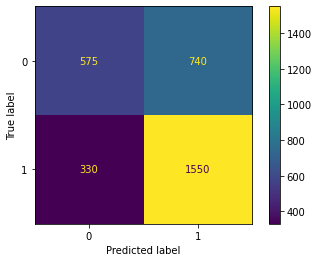

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test_both, grid_search_both.best_estimator_.predict(X_test_both))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

**Dataset 2:**

In [12]:
grid_search_seasons.fit(X_train_seasons, y_train_seasons.values.ravel())
print(grid_search_seasons.best_score_)

0.6709443265376123


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test_seasons, grid_search_seasons.best_estimator_.predict(X_test_seasons)))

              precision    recall  f1-score   support

       False       0.64      0.42      0.51      1315
        True       0.67      0.84      0.75      1880

    accuracy                           0.66      3195
   macro avg       0.66      0.63      0.63      3195
weighted avg       0.66      0.66      0.65      3195



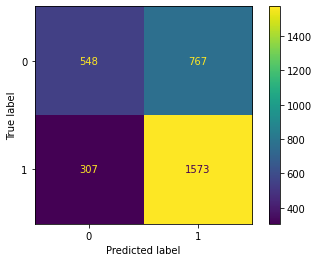

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test_seasons, grid_search_seasons.best_estimator_.predict(X_test_seasons))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

**Dataset 3:**

In [13]:
grid_search_during_restrictions.fit(X_train_during_restrictions, y_train_during_restrictions.values.ravel())
print(grid_search_during_restrictions.best_score_)

0.6717278710313631


In [18]:
print(classification_report(y_test_during_restrictions, grid_search_during_restrictions.best_estimator_.predict(X_test_during_restrictions)))

              precision    recall  f1-score   support

       False       0.64      0.45      0.53      1315
        True       0.68      0.82      0.74      1880

    accuracy                           0.67      3195
   macro avg       0.66      0.63      0.63      3195
weighted avg       0.66      0.67      0.65      3195



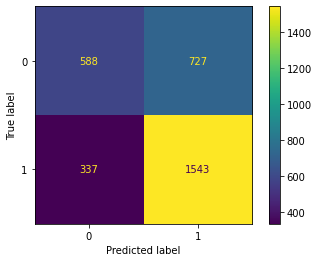

In [19]:
cm = confusion_matrix(y_test_during_restrictions, grid_search_during_restrictions.best_estimator_.predict(X_test_during_restrictions))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

**Dataset 4:**

In [14]:
grid_search_neither.fit(X_train_neither, y_train_neither.values.ravel())
print(grid_search_neither.best_score_)

0.6701620683002123


In [20]:
print(classification_report(y_test_neither, grid_search_neither.best_estimator_.predict(X_test_neither)))

              precision    recall  f1-score   support

       False       0.63      0.46      0.53      1315
        True       0.68      0.81      0.74      1880

    accuracy                           0.67      3195
   macro avg       0.66      0.64      0.64      3195
weighted avg       0.66      0.67      0.66      3195



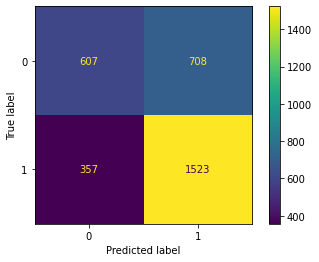

In [21]:
cm = confusion_matrix(y_test_neither, grid_search_neither.best_estimator_.predict(X_test_neither))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

**Evaluation**

Unfortunately, there seemed to be pretty much no difference in the scores outputted by the 4 different models. Even the precision, recall and F1 scores for positive and negative values had almost no change among the four values. Therefore, I can pretty safely conclude that neither feature had valuable enough predictive power to consider including in the model.
